# <center>Optimización de Hiperparámetros en NN con uso de  Callbacks</center>


Se usa el dataset: telecust.csv que parece complicado de mejorar

<a name="id8"></a>
**Métodos estudiados:**

1. [GRID con bucle](#id1)
2. [Sci-kit Learn GridSearhCV](#id2)
3. [Sci-kit Learn RandomizedSearchCV](#id3)
4. [Keras RandomSearch](#id4)
5. [Keras Hyperband](#id5)

Estudio y comparación de estos métodos de optimizar hiperparámetros.
Se consideran hiperparámetros en este estudio todos los que influyen en obtener el mejor resultado final, es decir, en hallar el modelo con mejor precisión.

Se incluyen:
- Parámetros de arquitectura o estructura de la red
    + [Numero de capas](#id6)
    + [Número de neuronas por capa](#id6) (en todas el mismo por no complicarlo)
- Parámetros de entrenamiento del modelo
    + [Epochs](#id6)
    + [Batch size](#id6)
- Parámetros de la red (hiperp. propiamente dichos)
    + [Función de activación de capa de entrada](#id6)
    + [Función de activación de capas ocultas](#id6)
    + [Optimizador del modelo](#id6) (aunque suele ser un hiperparámetro se ha fijado como Adam)

Se ha hecho uso de 2 **CALLBACKS** para mejorar la precisión y acelerar el proceso, que puede ser muy largo en los de fuerza bruta
1. Método [EarlyStopping](#id7) : para evitar overfit/variance
2. Método [ModelCheckpoint](#id7) : para grabar el modelo que ha conseguido mejor precisión durante la iteración


In [73]:
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorview as tv
from tensorflow.keras import losses, metrics,  optimizers, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner import HyperModel, HyperParameters, Hyperband

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import pydotplus
import matplotlib.image as mpimg


## Cargar Datos a partir de un archivo CSV 

In [2]:
df = pd.read_csv('~/Desktop/MLandPython/dataset archive/teleCust1000t.csv')
print(df.shape)
df.head()
#df['custcat'].value_counts()

(1000, 12)


,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


## Definimos X e y 

In [3]:
## Quito features para intentar bajar la varianza 
vars_dep = ['region','tenure','marital','income', 'ed', 'retire','gender', 'reside']

X = df[vars_dep].values
X.shape

(1000, 8)

In [4]:
## Defino la y
y_label = df.columns[-1]
classes_nb = len(df[y_label].unique())
print(classes_nb, 'clases\n')

y = df[y_label]
print(y.shape)
y.unique()

4 clases

(1000,)


array([1, 4, 3, 2])

## Codificamos la variable de salida
Lo hacemos adaptando a una red neuronal con 1 neurona de salida por cada clase en clasificación

One Hot Encoding

In [5]:
## Encode class values as integers (LabelEncoder)
## Convert integers to dummy variables (OneHotEncoder)
ohe = OneHotEncoder(sparse = False)
le = LabelEncoder()

dummy_y = le.fit_transform(y)
dummy_y = ohe.fit_transform(dummy_y.reshape(-1, 1))
dummy_y[0:10]

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

In [6]:
# # Con esto se revierten las codificaciones, puedo usarlo con la prediccion
# alreves = ohe.inverse_transform(y)
# alreves = alreves.reshape(1,-1)[0,:]
# alreves = le.inverse_transform(alreves)
# alreves

## Normalizar los Datos 

In [7]:
# Si el resultado es peor no lo hago
#X = MinMaxScaler().fit(X).transform(X.astype(float))
X = StandardScaler().fit(X).transform(X.astype(float))
X[0:5]


array([[-0.02696767, -1.055125  ,  1.0100505 , -0.12650641,  1.0877526 ,
        -0.22207644, -1.03459817, -0.23065004],
       [ 1.19883553, -1.14880563,  1.0100505 ,  0.54644972,  1.9062271 ,
        -0.22207644, -1.03459817,  2.55666158],
       [ 1.19883553,  1.52109247,  1.0100505 ,  0.35951747, -1.36767088,
        -0.22207644,  0.96655883, -0.23065004],
       [-0.02696767, -0.11831864, -0.9900495 , -0.41625141, -0.54919639,
        -0.22207644,  0.96655883, -0.92747794],
       [-0.02696767, -0.58672182,  1.0100505 , -0.44429125, -1.36767088,
        -0.22207644, -1.03459817,  1.16300577]])

## Aqui separo los datos en train y test


In [8]:
X_train, X_test, y_train, y_test = train_test_split( X, dummy_y, test_size=0.2, random_state=3)
print ('Set de Entrenamiento:', X_train.shape,  y_train.shape)
print ('Set de Prueba:', X_test.shape,  y_test.shape)
X_train.shape

Set de Entrenamiento: (800, 8) (800, 4)
Set de Prueba: (200, 8) (200, 4)


(800, 8)

##  
## Varias posibilidades de optimización de hiperparámetros

<a name="id1"></a>
## 1. GRID SEARCH de hiperparámetros:  con bucle (sin K-fold CV)

Prueba todas todas las combinaciones: fuerza bruta

1. Defino una función mia para crear y entrenar la NN con los parámetros que quiero
2. Defino los valores de los hiperparámetros y le aplico ParameterGrid (hace lista con todas las combinaciones)
3. Hago un bucle para Grid Search con:
    - Función crear y entrenar con cada combinación de parámetros
    - Evalúo y almaceno los resultados
4. Presento los resultados para poder elegir el mejor conjunto de hiperparámetros

Nota: Dentro del FIT uso X_test e y_test para ir viendo si hay Variance en las gráficas y también en el evaluate uso X_test e y_test

<a name="id7"></a>

In [127]:
# Implemento 2 Callbacks (además del que plotea)
# 1. Para evitar overfitting parando cuando no mejore: EarlyStopping
# 2. Para guardar el modelo con mejor precisión: ModelCheckPoint
# Tengo que meter los 2 Callback en el FIT

# Uso el loss para EarlyStopping y el accuracy para el ModelCheckPoint (aconsejado en Clasificación)
# Para Regresión se aconseja el mismo, por ej mse 
call_stop_early = EarlyStopping(monitor='val_Categorical cross-entropy', patience=20, mode='min', verbose=1)
call_model_checkp = ModelCheckpoint('best_model_hyp2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


In [128]:
#Creo función para crear y entrenar una NN de L capas y N neuronas, batch, epochs y activaciones seleccionables

def crea_entrena_red_Lcapas(capas=1, neuronas=32, activ_entr='relu', activ_hid='relu', activ_sal='softmax',
                 optimiser_mio='adam',epochs_ini=100, batch_ini=len(X_train)):
    
    metricNames = ['Categorical cross-entropy', 'Accuracy'] #'sparse_categorical_crossentropy'
    metricNamesRaw = ['loss', 'accuracy']
    
    model = Sequential()
    
    # Capa de entrada
    model.add(Dense(neuronas, input_dim = X_train.shape[1], activation=activ_entr))
    # Capas ocultas
    for i in range(1,capas):
        model.add(Dense(neuronas, activation=activ_hid))
    # Capa de salida    
    model.add(Dense(classes_nb, activation = activ_sal)) 
    model.compile(optimizer = optimiser_mio, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    #Hago el entrenamiento/fit mostrando precision entren y test
    tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,cell_size=(6,4), columns=2, iter_num=epochs_ini, wait_num=2)
    historyDense0 = model.fit(X_train, y_train,
                                epochs=epochs_ini, batch_size=batch_ini, 
                                validation_data = (X_test, y_test), 
                                verbose=0,
                                #class_weight = class_weight,
                                callbacks=[tvPlot, call_stop_early, call_model_checkp]
                             );
    return model

<a name="id6"></a>

In [84]:
## Optimizo los hiperparámetros
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid({
                 'capas':[1, 3, 5],
                 'neuronas':[8, 16, 32],
                 'activ_entr':['relu', 'selu', 'tanh'],
                 'activ_hid'   :['relu', 'sigmoid'],
                 'activ_sal'   :['softmax'],
                 'optimiser_mio'   :['adam'],
                 'epochs_ini':[25, 50, 100],
                 'batch_ini':[16, 32, 64]
                 
                })


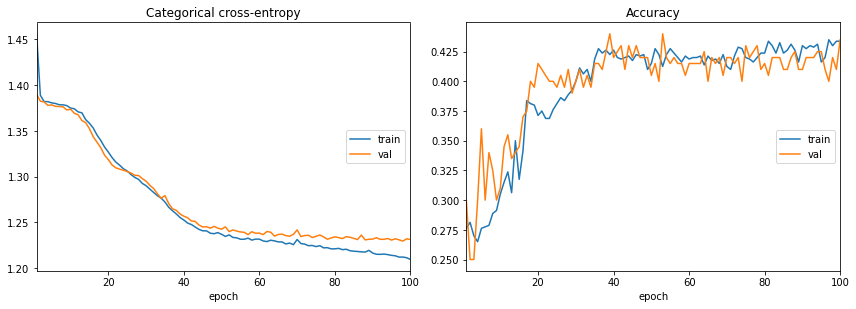

7/7 [==============================] - 0s 2ms/step - loss: 1.2314 - accuracy: 0.4350
Modelo: {'activ_entr': 'tanh', 'activ_hid': 'sigmoid', 'activ_sal': 'softmax', 'batch_ini': 64, 'capas': 5, 'epochs_ini': 100, 'neuronas': 32, 'optimiser_mio': 'adam'} ✓


In [85]:
# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    model = crea_entrena_red_Lcapas(**params)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(test_acc)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)

In [86]:
resultados.head(7)

,accuracy,activ_entr,activ_hid,activ_sal,batch_ini,capas,epochs_ini,neuronas,optimiser_mio
0,0.495,tanh,relu,softmax,32,1,25,16,adam
1,0.495,tanh,sigmoid,softmax,16,3,25,32,adam
2,0.480,selu,relu,softmax,16,1,50,16,adam
3,0.480,tanh,sigmoid,softmax,64,3,50,32,adam
4,0.475,selu,relu,softmax,64,1,100,16,adam
5,0.475,selu,sigmoid,softmax,64,3,50,32,adam
6,0.475,tanh,sigmoid,softmax,32,1,100,32,adam


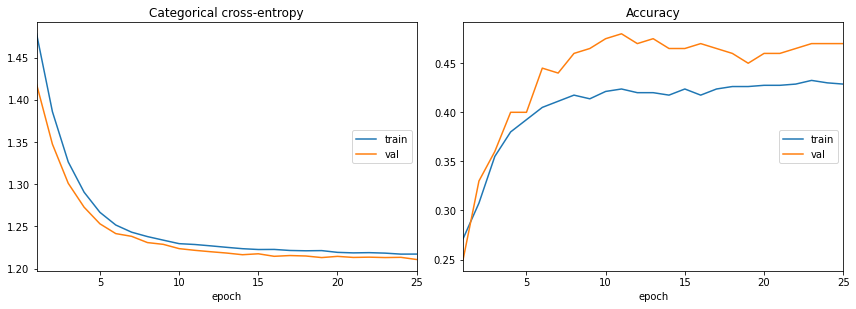


Precisión de entrenamiento:  0.42875
Precisión de test:  0.47

Precisión de entrenamiento del mejor (grabado):  0.41625
Precisión de test del mejor (grabado):  0.5


In [87]:

model = crea_entrena_red_Lcapas(capas=1,
                        neuronas=32,
                        activ_entr = 'tanh',
                        activ_hid = 'sigmoid',
                        activ_sal = 'softmax',
                        optimiser_mio = 'adam',
                        epochs_ini=25, 
                        batch_ini=32)

dummy_ypred = model.predict(X_train)
dummy_yhat = model.predict(X_test)
print("\nPrecisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

# Cargar el modelo guardado que es el de mejor precisión, no el que me da la función que es el ultimo 
saved_model = load_model('best_model.h5')

dummy_ypred = saved_model.predict(X_train)
dummy_yhat = saved_model.predict(X_test)
print("\nPrecisión de entrenamiento del mejor (grabado): ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test del mejor (grabado): ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

In [88]:
#Matriz del modelo
print("Modelo de 3 capas 32 neuronas\n")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1), labels=range(0,classes_nb)))
print (classification_report(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))


Modelo de 3 capas 32 neuronas

[[37  0  5  8]
 [ 8  8 14 13]
 [20  2 31  7]
 [12  2  9 24]]
              precision    recall  f1-score   support

           0       0.48      0.74      0.58        50
           1       0.67      0.19      0.29        43
           2       0.53      0.52      0.52        60
           3       0.46      0.51      0.48        47

    accuracy                           0.50       200
   macro avg       0.53      0.49      0.47       200
weighted avg       0.53      0.50      0.48       200



<a name="id2"></a>
## 2. GRID SEARCH de hiperparámetros:  función sklearn GridSearchCV (incluye K-fold CV)

Prueba todas todas las combinaciones: fuerza bruta

1. Defino una función mia para crear (no entrenar) la NN con los parámetros que quiero
2. Defino los valores de los hiperparámetros como un diccionario (sin ParameterGrid)
3. Creo un modelo tipo KerasClassifier (crea un estimator con mi funcion creadora, que tiene fit y score)
4. Creo objeto de la clase GridSearchCV (que necesita un estimator que tenga fit y score)
5. Hago fit con él  (supongo que llama al fit de KerasClassifier que llama al fit del modelo de NN mio que es un Sequence de NN)

Funcionamiento: Al hacer K-fold CV, se entrena el modelo con k-1/k partes del training set y se evalua con el 1/k parte (evaluation set) y eso para cada combinación de parámetros. Con la mejor comb se vuelve a entrenar por ultima vez pero con TODO el training set.

Evaluación final: hay que hacerla con el test set (X_test, y_test) y ese es el dato final

In [45]:
def crea_red_Lcapas(capas=1, neuronas=32,
                    activ_entr='relu', activ_hid='relu', activ_sal='softmax',
                    optimiser_mio='adam'):
    
    metricNames = ['Categorical cross-entropy', 'Accuracy'] #'sparse_categorical_crossentropy'
    metricNamesRaw = ['loss', 'accuracy']
    
    model = Sequential()
    
    # Capa de entrada
    model.add(Dense(neuronas, input_dim = X_train.shape[1], activation=activ_entr))
    # Capas ocultas
    for i in range(1,capas):
        model.add(Dense(neuronas, activation=activ_hid))
    # Capa de salida    
    model.add(Dense(classes_nb, activation = activ_sal)) 
    model.compile(optimizer = optimiser_mio, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

In [124]:
parametros = {
            'capas':[1, 3, 5],
            'neuronas':[8, 16, 32],
            'activ_entr':['relu', 'selu', 'tanh'],
            'activ_hid'   :['relu', 'sigmoid'],
            'activ_sal'   :['softmax'],
            'optimiser_mio'   :['adam'],
            'epochs':[25, 50, 100],
            'batch_size':[16, 32, 64]
            }

In [125]:
# Creo un objeto de tipo KerasClassifier y lo meto como parámetro para crear un objeto tipo GridSearchCV
# Lo hago con refit al final, por defecto es True, para que lo entrene con todo el train y ver score con el test
model_wrapper = KerasClassifier(build_fn=crea_red_Lcapas)
grid = GridSearchCV(model_wrapper, parametros, cv=5,verbose=1, return_train_score=True)

# Hago el fit del ultimo tipo de objeto que supongo llamará al fit de los anteriores
grid.fit(X_train, y_train, verbose=0)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
17/17 [==============================] - 0s 1ms/step - loss: 1.1941 - accuracy: 0.4522


9/9 [==============================] - 0s 2ms/step - loss: 1.1766 - accuracy: 0.4494


GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb6e27293a0>,
             param_grid={'activ_entr': ['relu', 'selu', 'tanh'],
                         'activ_hid': ['relu', 'sigmoid'],
                         'activ_sal': ['softmax'], 'batch_size': [16, 32, 64],
                         'capas': [3], 'epochs': [25, 50, 100],
                         'neuronas': [32], 'optimiser_mio': ['adam']},
             return_train_score=True, verbose=1)

In [90]:
# Presento los resultados
d = pd.DataFrame(grid.cv_results_)
#d
d[['param_activ_entr','param_activ_hid','param_batch_size','param_epochs',
   'mean_test_score','mean_train_score','rank_test_score']].sort_values('rank_test_score').head()

,param_activ_entr,param_activ_hid,param_batch_size,param_epochs,mean_test_score,mean_train_score,rank_test_score
10,relu,sigmoid,16,50,0.402495,0.475624,1
48,tanh,sigmoid,32,25,0.394990,0.431250,2
17,relu,sigmoid,64,100,0.394981,0.491254,3
9,relu,sigmoid,16,25,0.392465,0.450632,4
15,relu,sigmoid,64,25,0.391203,0.436248,5


In [119]:
# Estos resultados aunque los llaman test_score es con datos dentro del training data
# Que son menos del total y puede que baje la precisión
print(grid.best_params_)
print(grid.best_score_)

# Estos sin embargo ya son equivalentes 
# porque vuelvo a entrenar el modelo con los parámetros mejores y todo el train data y comparo con el test data
# PERO EL CASO ES QUE DA BASTANTE PEOR !!!!

dummy_ypred = grid.predict(X_train)
dummy_yhat = grid.predict(X_test)
print("\nPrecisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), dummy_ypred))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), dummy_yhat))

{'activ_entr': 'relu', 'activ_hid': 'sigmoid', 'activ_sal': 'softmax', 'batch_size': 16, 'capas': 5, 'epochs': 50, 'neuronas': 64, 'optimiser_mio': 'adam'}
0.40249499678611755

Precisión de entrenamiento:  0.46
Precisión de test:  0.365


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


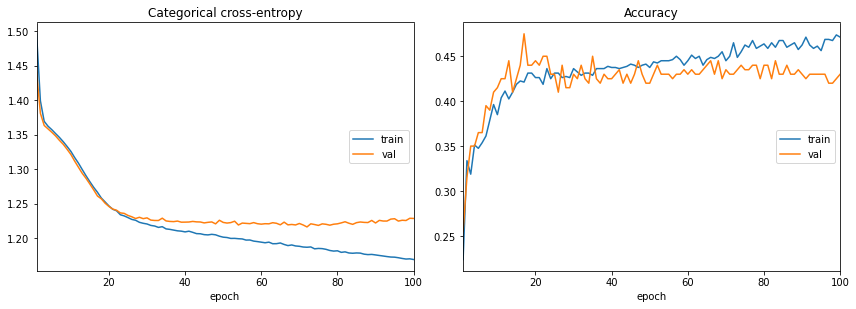


Precisión de entrenamiento:  0.47125
Precisión de test:  0.43


In [128]:
##############################################
#Hay conjuntos de parámetros claramente mejores. 
#Me parece peor el GridSearchCV que el que se hace a mano sin CV
##############################################

model = crea_entrena_red_Lcapas(capas=3,
                        neuronas=32,
                        activ_entr = 'relu',
                        activ_hid = 'sigmoid',
                        activ_sal = 'softmax',
                        optimiser_mio = 'adam',
                        epochs_ini=100, 
                        batch_ini=64)

dummy_ypred = model.predict(X_train)
dummy_yhat = model.predict(X_test)
print("\nPrecisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

# Cargar el modelo guardado que es el de mejor precisión, no el que me da la función que es el ultimo 
saved_model = load_model('best_model.h5')

dummy_ypred = saved_model.predict(X_train)
dummy_yhat = saved_model.predict(X_test)
print("\nPrecisión de entrenamiento del mejor (grabado): ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test del mejor (grabado): ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

<a name="id3"></a>
## 3. GRID SEARCH de hiperparámetros:  función sklearn RandomizedSearchCV (con K-fold CV)

Prueba solo unas cuantas combinaciones

Los mismos pasos:
1. Uso la función definida para crear (no entrenar) la NN con los parámetros que quiero
2. Defino los valores de los hiperparámetros: AHORA puedo especificar rangos de valores y que elija al azar
3. Creo un modelo tipo KerasClassifier 
4. Creo objeto de la clase AHORA RandomizedSearchCV  
5. Uso Metodo fit con él  

Funcionamiento: Igual

Evaluación final: Igual

In [89]:
parametros_rand = {
            'capas':range(1, 5, 2),
            'neuronas':[8, 16, 32],
            'activ_entr':['selu','tanh','relu'],
            'activ_hid'   :['relu','sigmoid'],
            'activ_sal'   :['softmax'],
            'optimiser_mio'   :['adam'],
            'epochs':[25, 50, 100],
            'batch_size': [16, 32, 64]
            }

In [90]:
# Creo un objeto de tipo KerasClassifier y lo meto como parámetro para crear un objeto tipo GridSearchCV
np.random.seed(42)
model_wrapper = KerasClassifier(build_fn=crea_red_Lcapas)
rand = RandomizedSearchCV(model_wrapper, parametros_rand, cv=5,verbose=1, return_train_score=True)

# El n_iter más alto, más combinaciones de parámetros al azar, no mejora
# El cv=3 a 5, más porcentaje de entrenamiento y menos evaluación SI mejora

# Hago el fit del utlimo tipo de objeto que supongo llamará al fit de los anteriores
rand.fit(X_train, y_train, verbose=0)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
10/10 [==============================] - 0s 2ms/step - loss: 1.3493 - accuracy: 0.3672


RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb69bdcec10>,
                   param_distributions={'activ_entr': ['selu', 'tanh', 'relu'],
                                        'activ_hid': ['relu', 'sigmoid'],
                                        'activ_sal': ['softmax'],
                                        'batch_size': [16, 32, 64],
                                        'capas': range(1, 5, 2),
                                        'epochs': [25, 50, 100],
                                        'neuronas': [8, 16, 32],
                                        'optimiser_mio': ['adam']},
                   return_train_score=True, verbose=1)

In [91]:
# Presento los resultados
r = pd.DataFrame(rand.cv_results_)
#r
r[['param_capas','param_neuronas','param_epochs','param_batch_size','param_activ_entr','param_activ_hid',
   'mean_test_score','mean_train_score','rank_test_score']].sort_values('rank_test_score').head()

,param_capas,param_neuronas,param_epochs,param_batch_size,param_activ_entr,param_activ_hid,mean_test_score,mean_train_score,rank_test_score
0,1,8,100,32,tanh,relu,0.40250,0.445000,1
2,3,32,25,32,tanh,relu,0.39500,0.507500,2
6,1,8,50,16,relu,relu,0.38875,0.441250,3
4,1,8,25,32,tanh,sigmoid,0.38750,0.416875,4
7,3,16,100,32,tanh,sigmoid,0.38750,0.445000,4


In [92]:
# Estos resultados aunque los llaman test_score es con datos dentro del training data
# Que son menos del total y puede que baje la precisión
print(rand.best_params_)
print(rand.best_score_)

# Estos sin embargo ya son equivalentes 

dummy_ypred = rand.predict(X_train)
dummy_yhat = rand.predict(X_test)
print("\nPrecisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), dummy_ypred))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), dummy_yhat))

{'optimiser_mio': 'adam', 'neuronas': 8, 'epochs': 100, 'capas': 1, 'batch_size': 32, 'activ_sal': 'softmax', 'activ_hid': 'relu', 'activ_entr': 'tanh'}
0.40249999761581423


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



Precisión de entrenamiento:  0.43875
Precisión de test:  0.425


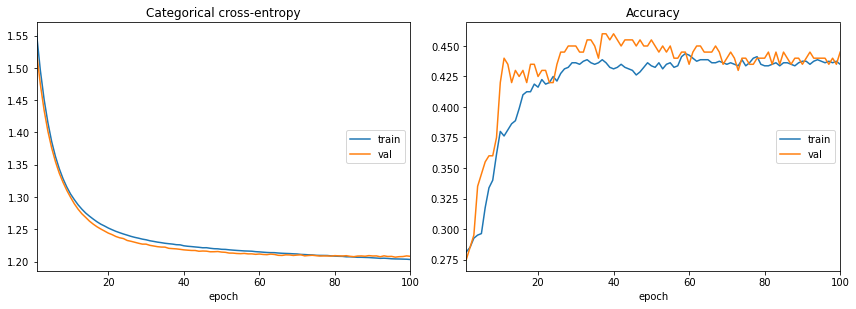


Precisión de entrenamiento:  0.43625
Precisión de test:  0.445

Precisión de entrenamiento del mejor (grabado):  0.44
Precisión de test del mejor (grabado):  0.46


In [97]:
model = crea_entrena_red_Lcapas(capas=1,
                        neuronas=8,
                        activ_entr = 'tanh',
                        activ_hid = 'relu',
                        activ_sal = 'softmax',
                        optimiser_mio = 'adam',
                        epochs_ini=100, 
                        batch_ini=32)

dummy_ypred = model.predict(X_train)
dummy_yhat = model.predict(X_test)
print("\nPrecisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

# Cargar el modelo guardado que es el de mejor precisión, no el que me da la función que es el ultimo 
saved_model = load_model('best_model_rand.h5')

dummy_ypred = saved_model.predict(X_train)
dummy_yhat = saved_model.predict(X_test)
print("\nPrecisión de entrenamiento del mejor (grabado): ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test del mejor (grabado): ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

In [98]:
#Matriz del modelo
print("Modelo de 3 capas 32 neuronas\n")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1), labels=range(0,classes_nb)))
print (classification_report(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))


Modelo de 3 capas 32 neuronas

[[24  2 16  8]
 [ 7 15 10 11]
 [16  5 33  6]
 [11  6 10 20]]
              precision    recall  f1-score   support

           0       0.41      0.48      0.44        50
           1       0.54      0.35      0.42        43
           2       0.48      0.55      0.51        60
           3       0.44      0.43      0.43        47

    accuracy                           0.46       200
   macro avg       0.47      0.45      0.45       200
weighted avg       0.47      0.46      0.46       200



<a name="id4"></a>
## 4. GRID SEARCH de hiperparámetros:  función de Keras RandomSearch (con K-fold CV)

Prueba solo unas cuantas combinaciones al azar

Problema: no se sabe cuales son los epochs y batch mejores 

Puede hacerse de 2 formas:
1. Defino una CLASE de objeto hijo de HyperModel (hereda) con un método Build 
2. Defino una función Build y ya está 

Uso la 2ª que es más fácil. Proceso:
1. Pongo los valores de los hiperparámetros dentro del método/función Build (var hp tipo hyperparameter)
2. Creo objeto tipo RandomSearch y le paso la función Build como parámetro
    (si uso el 1º le paso una instancia de mi nueva CLASE)
3. Uso Metodo "search" con él  


In [102]:
def build_model(hp):
        
        cap = hp.Int('capas', min_value=1, max_value=5, step=2)
        neu = hp.Choice('neuronas', values=[8, 16, 32])
        act_e = hp.Choice('activ_entr', values=['selu','tanh','relu'])
        act_h = hp.Choice('activ_hid', values=['sigmoid','relu'])
    
        model = Sequential()
        # Capa de entrada
        model.add(Dense(units=neu,
                        input_dim = X_train.shape[1], 
                        activation=act_e))
        # Capas ocultas
        for i in range(1,cap):
            model.add(Dense(neu, activation=act_h))
        # Capa de salida    
        model.add(Dense(classes_nb, activation = 'softmax')) 
        model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy']) 

        return model

In [103]:
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     seed=42,
                     max_trials=10,
                     overwrite=True
                     #executions_per_trial=EXECUTION_PER_TRIAL,
                     #directory='random_search'
                     )
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.36000001430511475

Best val_accuracy So Far: 0.4300000071525574
Total elapsed time: 00h 00m 37s
INFO:tensorflow:Oracle triggered exit


In [104]:
#m = tuner.get_best_models(num_models=1)
#tuner.search_space_summary()
tuner.results_summary(3)

Results summary
Results in ./untitled_project
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
capas: 5
neuronas: 16
activ_entr: tanh
activ_hid: relu
Score: 0.4300000071525574
Trial summary
Hyperparameters:
capas: 5
neuronas: 16
activ_entr: selu
activ_hid: relu
Score: 0.41999998688697815
Trial summary
Hyperparameters:
capas: 1
neuronas: 8
activ_entr: relu
activ_hid: sigmoid
Score: 0.4050000011920929


In [105]:
m = tuner.get_best_models(num_models=1)
dummy_ypred = m[0].predict(X_train)
dummy_yhat = m[0].predict(X_test)
print("\bnPrecisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

nPrecisión de entrenamiento:  0.44375
Precisión de test:  0.43


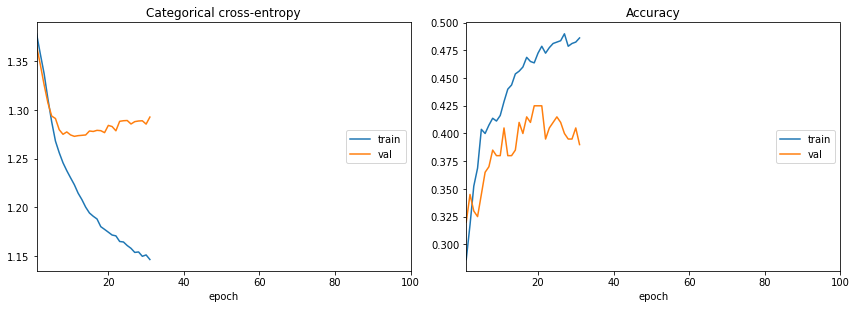

Epoch 00031: early stopping

Precisión de entrenamiento:  0.4925
Precisión de test:  0.39

Precisión de entrenamiento del mejor (grabado):  0.47875
Precisión de test del mejor (grabado):  0.425


In [108]:
# No sé qué epochs y batch ha usado para obtener el mejor modelo
# Debo volver a optimizarlo o averiguarlo
# Aqui con estos valores parece que sale bastante cerca del resultado del "buscador"
model = crea_entrena_red_Lcapas(capas=5,
                        neuronas=16,
                        activ_entr = 'tanh',
                        activ_hid = 'relu',
                        activ_sal = 'softmax',
                        optimiser_mio = 'adam',
                        epochs_ini=100, 
                        batch_ini=32)

dummy_ypred = model.predict(X_train)
dummy_yhat = model.predict(X_test)
print("\nPrecisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

# Cargar el modelo guardado que es el de mejor precisión, no el que me da la función que es el ultimo 
saved_model = load_model('best_model_rand2.h5')

dummy_ypred = saved_model.predict(X_train)
dummy_yhat = saved_model.predict(X_test)
print("\nPrecisión de entrenamiento del mejor (grabado): ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test del mejor (grabado): ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

In [109]:
################   Esta es la segunda forma de haccerlo   #####################
# class MyHypermodelNN (HyperModel):
    
#     def __init__(self, input_shape, num_classes):
#         self.num_classes = num_classes
#         self.input_shape = input_shape
        
#     def build(self, hp2):
        
#         model = Sequential()

#         # Capa de entrada
#         model.add(Dense(hp2.Choice('neuronas', values=[8, 32, 64]),
#                         input_dim = self.input_shape, 
#                         activation = hp2.Choice('activ_entr', values=['selu','sigmoid','relu'])
#                        ))
#         # Capas ocultas
#         for i in range(1,hp2.Int('capas', min_value=1, max_value=5, step=1)):
#             model.add(Dense(hp2.Choice('neuronas', values=[8, 32, 64]),
#                             activation = hp2.Choice('activ_hid', values=['sigmoid','relu'])))
#         # Capa de salida    
#         model.add(Dense(self.num_classes, activation = 'softmax')) 
#         model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy']) 
        
#         return model

## Override los parámetros que hay dentro del método
#hp = HyperParameters()

# hp.Int('capas', min_value=1, max_value=5, step=1)
# hp.Choice('neuronas', values=[8, 32, 64])
# hp.Choice('activ_entr', values=['selu','tanh','relu'])
# hp.Choice('activ_hid', values=['sigmoid','relu'])
# hp.Choice('activ_sal', values=['softmax'])
# hp.Choice('optimiser_mio', values=['adam'])

# hp.Choice('epochs', values=[25, 50, 100, 200])
# hp.Int('batch_size',
#        min_value=16,
#        max_value=256,
#        step=32)


# hm = MyHypermodelNN(X_train.shape[1], classes_nb)
# tuner = RandomSearch(hm,
#                      objective='val_accuracy',
#                      seed=42,
#                      max_trials=10,
#                      directory='random_search',
#                      project_name='con clase nueva')

# tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

<a name="id5"></a>
## 5. GRID SEARCH de hiperparámetros:  función de Keras Hyperband (con K-fold CV ??)

Prueba solo unas cuantas combinaciones y por competición va seleccionando

Problema: no se sabe cual es el mejor batch. El epoch lo puedo sacar porque hace Early Stopping 

Puede hacerse de las mismas 2 formas también.

Uso la 2ª: función build

In [141]:
# Hace Callbacks de EarlyStopping en cada iteracion de optimización
# Parece que va mejor si pongo accuracy en lugar de loss, como está en la función de creación
# y que tan buenos resultados ha dado ne el grid saearch de fuerza bruta
# Ha pasado de considerar el mejor uno de 5 capas y 32 neuronas a uno de 1 capa y 32 y resulta mejor
c_se = EarlyStopping(monitor='val_accuracy', patience=20, mode='min', verbose=1)
c_mc = ModelCheckpoint('best_model_hyp3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

## Instancia del grid search al que paso la función build como parámetro

hb_tuner = Hyperband(build_model,
                     max_epochs=100,
                     objective='val_accuracy',
                     seed=42,
                     hyperband_iterations=10,
                     executions_per_trial=5,
                     directory='hyperband_search',
                     overwrite=True)

# Es como un fit del modelo
hb_tuner.search(X_train, y_train, 
                validation_data=(X_test, y_test),
                verbose=1,
                epochs=100,
                callbacks=[c_se, c_mc]
               )

Trial 52 Complete [00h 00m 06s]
val_accuracy: 0.3439999997615814

Best val_accuracy So Far: 0.3949999988079071
Total elapsed time: 00h 06m 19s
INFO:tensorflow:Oracle triggered exit


In [142]:
hb_tuner.results_summary(3)

Results summary
Results in hyperband_search/untitled_project
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
capas: 1
neuronas: 32
activ_entr: selu
activ_hid: relu
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.3949999988079071
Trial summary
Hyperparameters:
capas: 3
neuronas: 32
activ_entr: selu
activ_hid: relu
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.3899999976158142
Trial summary
Hyperparameters:
capas: 3
neuronas: 32
activ_entr: tanh
activ_hid: relu
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.38899999260902407


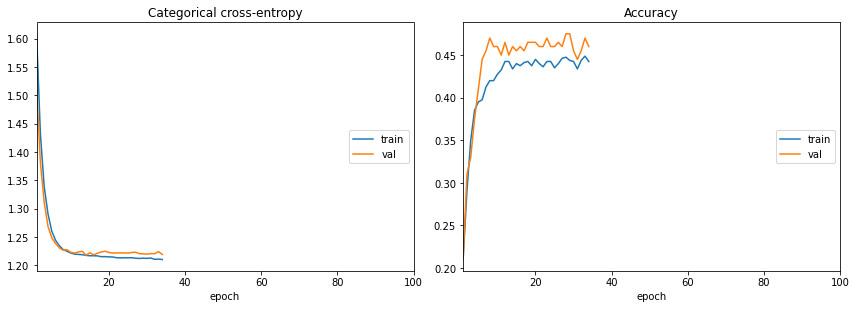

Epoch 00034: early stopping


In [143]:
# No sé muy bien qué epochs y batch ha usado para obtener el mejor modelo
# Puedo deducirlo de los numeros que aparecen si pongo verbose=1
model = crea_entrena_red_Lcapas(capas=1,
                        neuronas=32,
                        activ_entr = 'selu',
                        activ_hid = 'relu',
                        activ_sal = 'softmax',
                        optimiser_mio = 'adam',
                        epochs_ini=100, 
                        batch_ini=32)


In [144]:
dummy_ypred = model.predict(X_train)
dummy_yhat = model.predict(X_test)
print("\nPrecisión de entrenamiento del ultimo modelo: ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test del ultimo modelo: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

# Cargar el modelo guardado que es el de mejor precisión, no el que me da la función que es el ultimo 
saved_model = load_model('best_model_hyp2.h5')

dummy_ypred = saved_model.predict(X_train)
dummy_yhat = saved_model.predict(X_test)
print("\nPrecisión de entrenamiento del mejor (grabado): ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test del mejor (grabado): ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))


Precisión de entrenamiento del ultimo modelo:  0.43875
Precisión de test del ultimo modelo:  0.46

Precisión de entrenamiento del mejor (grabado):  0.445
Precisión de test del mejor (grabado):  0.475


In [145]:
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________


# CONCLUSIONES

- El método **GRID con bucle** es el que mejor modelo encuentra, pero al hacerlo con todos las combinaciones lleva mucho tiempo. No incluye K-fold CV y usa el conjunto de test del 20%, para validar modelos durante la iteración. El overfit se trata de evitar, no con CV sino con los callbacks: EarlyStopping y ModelCheckPoints.
- El método **GridSearchCV** de Sci-kit Learn, que también es por fuerza bruta, consigue peores resultados porque incluye 5-fold CV. Eso significa quitar un 20% al conjunto de train para validar los modelos, con lo que se entrenan los modelos con solo un 64% y los resultados son peores.
- El método **RandomizedSearchCV** de Sci-kit Learn, es un buen compromiso entre duración y resultado. Explorar un número mayor de 10 de conjuntos de parámetros al azar no mejora el resultado. Sin embargo un cv de 5 en lugar de 3 si que lo mejora, al entrenar los modelos con más datos.
- El método **RandomSearch** de Keras, no resulta práctico porque optimiza epochs y batch por su cuenta. Al obtener el mejor modelo se vuelve a entrenar con todo el train set pero no se conoce que epochs y batch dieron el mejor resultado. habría que optimizarlos de nuevo.
- El método **Hyperband** de Keras, también es un buen compromiso entre resultado y tiempo. Tampoco se conoce el batch que usa, pero se puede sacar con la información mostrada con verbose=1. El epoch se puede conocer si se usa el callback EarlyStopping, porque es con el que se para.

[Retorno al principio](#id8)